# 5) Algorithm analysis
This notebook will examine some of the properties of the algorithm and various design decisions.  In this paper, the cipher algorithm is four rounds of the Feistel Network (FN) using a modified DES round function named RF().  

Initially the cipher algorithm chosen to study was a two round Feisel network.  However, after analyzing some of the characteristics of using only two rounds, I noticed that a one character change within the plaintext block did not fully propagate to all the other characters in the block when encrypted.  Also it was noticed that the algorithm was sensitive to one or two errors in the key.  So the algorithm was adjusted to include additional rounds and the key schedule was modified to generate round keys that reduced the key error sensitivity. 

The analysis will start with looking at the letter frequency of the cipher text.  Then the following topics are discussed. 

- 5.a) [Ciphertext letter frequency](#section5a)  
- 5.b) [Key space](#section5b) 
- 5.c) [Sensitivity to errors in the key](#section5c) 
- 5.d) [Sensitivity to changes in the message](#section5d) 
- 5.e) [Repeating text in the message](#section5e) 
- 5.f) [Round function properties](#section5f) 
- 5.g) [Section summary](#section5g) 
- 5.h) [References](#section5h) 


**ToDo:**  
- ~~finish section summary~~
- ~~remove old code~~
- ~~expand narration~~~
- spell check

In [1]:
from collections import Counter
import itertools
import random
import pickle
import sys
import numpy as np
import matplotlib.pyplot as plt
from myModule import *

In [2]:
from scipy.special import comb
from Crypto.Hash import SHA512
import re
from scipy.stats import chisquare
import base64

In [3]:
# Loading objects created in the main notebook.
with open('objs.pkl', 'rb') as f:
    block_size,PT,PT_int,key,IV,Mixer,S_box,P_table,en_letter_freq = pickle.load(f)

## 5.a) Ciphertext letter frequency <a id="section5a"></a>
One of the design goals of the cipher is to flatten the letter and n-gram frequency characteristics to thwart letter frequency analysis.  As shown in section 6b, the cipher accomplishes this goal.

## 5.b) Key space <a id="section5b"></a>
The key length for the cipher in the cipher is equal to the block size.  If the key space is too small then a fast computer or special hardware can attack the cipher by trying all possible keys, provided that valid plain text can be discriminated from noise.  

### Key length comparison
The number of possible keys in the key space is made from all combinations of 26 letters with a length equal to the block length.  The key length is equal to the block length so the key space could be made larger by increasing the block length. Calculating the size of the key space assumes that keys are chosen from the pool of all possible keys.  Choosing keys from combinations of English words, as we have done, limits the size of the pool.

In [4]:
# number of characters in key is equal to the block size and there are 26 characters in the alphabet
print('key space for {:d} character keys: {:,d}'.format(block_size,26**block_size))

key space for 16 character keys: 43,608,742,899,428,874,059,776


In [5]:
# the key space expressed in equivalent number of bits
print('a {:d} character long key is equal to {:.1f} bits'.format(block_size,np.log2(float(26**block_size))))

a 16 character long key is equal to 75.2 bits


What if the block size was changed?

In [6]:
new_block_size = 40
print('key space for {:d} character keys: {:,d}'.format(new_block_size,26**new_block_size))

key space for 40 character keys: 397,131,118,389,635,994,560,666,234,198,316,439,032,157,304,558,637,285,376


In [7]:
# the key space expressed in equivalent number of bits
print('{:d} character long key is equal to a {:.1f} bit long key'.format(new_block_size,np.log2(float(26**new_block_size))))

40 character long key is equal to a 188.0 bit long key


Now the key space is very large.  

Below, the key space is calculated for DES which uses a 56 bit key.

In [8]:
print('DES key space: {:,d}'.format(2**56))

DES key space: 72,057,594,037,927,936


In [9]:
print('Compared to the DES key space of 56 bits, the key space from 16 letters is {:,.0f} times larger'.format(26**block_size/2**56))    

Compared to the DES key space of 56 bits, the key space from 16 letters is 605,193 times larger


The Enigma has 158,962,555,217,826,360,000 possible different settings [1], which is less than the key space of 16 letters.

In [10]:
# the key space expressed in equivalent number of bits
print('Enigma settings are equal to a {:.1f} bit key'.format(np.log2(float(158962555217826360000))))

Enigma settings are equal to a 67.1 bit key


The AES key space of 256 bits is extremely large.

In [11]:
print('AES key space: {:,d}'.format(2**256))

AES key space: 115,792,089,237,316,195,423,570,985,008,687,907,853,269,984,665,640,564,039,457,584,007,913,129,639,936


In this paper, the key was chosen from animal names (recall that the key phrase is: 'elephantzebratigermonkeylion').  Following the same idea of using random English words to build the key, there are about 470,000 words in a typical English language dictionary [2].  The following calculation looks at the key space size from using words from a dictionary or a word list.  Here we assume that 3 words of sufficient length are used to make the 16 character key.   

In [12]:
word_phase_len = 3
print('English dictionary # of {:d} word combinations: {:,.0f}'.format(word_phase_len,comb(470000,word_phase_len)))

English dictionary # of 3 word combinations: 17,303,722,883,490,000


We can see that limiting the key to using English words significantly reduces the key space.  However, sixteen random letters are much harder to remember than several English words.  The above calculations suggest that three random words provide less protection from a brute force key guessing attack than the DES or the Enigma.   

So if we want to improve the protection against a brute force key guessing attack, we need at least 4 random words as shown below to have about the same level of protections as the Enigma.

In [13]:
word_phase_len = 4
print('number of {:d} word combinations in English dictionary: {:,.0f}'.format(word_phase_len,comb(470000*0.80,word_phase_len)))

number of 4 word combinations in English dictionary: 832,785,601,387,463,835,648


Assuming that 80% of the words in the dictionary are words we would actually might use, there are 832,785,601,387,463,835,648 combinations of 4 words.  This exceeds the DES key space and about the same size as the Enigma key space. 

One idea for generating stronger keys from English words is to use a longer pass phase, say of 6 or more words, then calculate a hash of the pass phrase and encode the result to get back to 16 characters made up of English letters. The following code loads the word list and extracts the words that have between 3 and 9 characters.   

In [14]:
rng = random.SystemRandom  # set up the random variable

In [15]:
words = []
min_length = 3
max_length = 9
valid_chars = '.'
regexp = re.compile("^{0}{{{1},{2}}}$".format(valid_chars,min_length,max_length))

In [16]:
# read words from file into wordlist
with open('/home/jim/Documents/JupyterLab/Misc ipython notebooks/wordlist.txt') as wlf:
    for line in wlf:
        thisword = line.strip()
        if regexp.match(thisword) is not None:
            words.append(thisword)
wordlist = list(set(words))

In [17]:
pass_phase_len = 6 # number of words in the pass phrase
delimiter = ' '
pass_phrase = delimiter.join(rng().choice(wordlist) for i in range(pass_phase_len)).encode('ascii')
print(pass_phrase)

b'touchdown pelt storied reusable otter Commons'


In [18]:
print('number of {:d} word combinations in word list: {:,.0f}'.format(pass_phase_len,comb(len(wordlist),pass_phase_len)))

number of 6 word combinations in word list: 7,634,007,403,751,550,700,486,656


The number of combinations of words with length between 3 and 9 characters long exceeds the DES key space.  The more random words in the pass phrase length, the harder it is to remember and you would probably just resort to writing them down.

In [19]:
# now create a hash of the pass phrase
hash = SHA512.new()
hash.update(pass_phrase)
p = hash.digest()
print(p)

b"\xb0\xe2\xbcv!\x0b\xb5S\x8d\xa3\xd1B\t\xc0k\xd2$\xd01\x9a`\x97f\x8e\xc1\xad\xea\x91*B\xcb-\xae9\xcd*\xc7\xa0\x17\xb9|\xf4\xc9\x9f\xfa\xa0-\x8e\x86kw\xe9L^!\xc3m\x98'S\x89Tg\xc3"


The hash value, p, is a binary string which we can encode using base32 and then strip the non alphabetic characters from the string and use the first 16 characters as the new key derived from the pass phrase.

In [20]:
key_string = base64.b32encode(p)
print(key_string)

b'WDRLY5RBBO2VHDND2FBATQDL2ISNAMM2MCLWNDWBVXVJCKSCZMW24OONFLD2AF5ZPT2MTH72UAWY5BTLO7UUYXRBYNWZQJ2TRFKGPQY='


In [21]:
pw = ''
for e in list(key_string):
    if chr(e).isalpha():
        pw += chr(e)
print('password generated from pass phrase: {:s}'.format(pw[0:block_size]))

pass word generated from pass phrase: WDRLYRBBOVHDNDFB


Observation:  
The code above describes one way to generate a 16 character password from random English words.  The normal python random function is used and that's probably OK since the seed is a secret.  The python secret module could be used if a secure random number generated is needed.  In this paper, it's not needed because this is only a educational project.

The size of the key space was used to compare various encryption algorithms.  If the key space is too small, then a brute force attack is a consideration.   

**Key management**  
The following describes a key management scheme patterned after the scheme used for the Enigma.  
Code books:  Publish a secret code book that has a unique random key and day-IV for each day of the month.   
Message key:  Every message sent during the day uses the same daily key, but a different msg-IV.  The msg-IV is chosen at random by the operator and should always be unique.  Repeated messages should use a different msg-IV.  The msg-IV is encrypted with the day-key and the day-IV.  The encrypted msg-IV is sent as the first block of the message.  The receiving operator decrypts the first block using the day-key and the day-IV to recover the msg-IV.  Then the recovered msg-IV along with the day-key is used to decrypt the message.  Long messages should be broken into short parts not to exceed 500 characters.  Each part should use a unique msg-IV.

## 5.c) Sensitivity to errors in the key <a id="section5c"></a>
In this section we will look at the sensitivity of decryption to errors in the key.  This is instructive to learn how close a guess of the key needs to be to start seeing correct plaintext.   

Using the CBC mode, the test message is encrypted.

In [22]:
ct_temp_int = encrypt_CBC(PT_int,key,IV)

# convert back to ascii characters and display
ct_temp_ascii = (ct_temp_int+ord('A')).tostring().decode('ascii')

string = ct_temp_ascii
length = 75
list_of_strings = []
for i in range(0, len(string), length):
    list_of_strings.append(string[i:length+i])

for i in list_of_strings:
    print(i)

PPVKERWGBMZDFXPWOEAJBELYWGIPZKKABJKUPZJVNCNOXWCKQZFTPEXAAZTMOEXSHZOZHMRKZDM
EFHYFSKGKQRGEAIPYGKQZSYBPQILDMTSVCRXKASTCCZCDSEXSBRNRSCIFJWVIAXRFCCOBJQVLPZ
FNESRTSOJOGVGWZUYNPLXIHLDNKMLGVUJCHYITYEYJFRLCWYYSOJMBYVFNAYSMVIBJUIMGUBEDS
OPJHCALRRFXLUCTSHFAXFWIVAGRDEZLZHWPKTNGURWRTASQFSKLSKLOMMDWGMJGPPGHYECOIPET
ATIJNKGROGBHJDWXBWJFTSULTQKIISTHSYSQYLPBCBQEYDIDGKNXNBAAOOKXFZYCBJQZLSYVCAZ
SGOZFOHAPFCVNQAVBDTHXHVEXGSFVQEFQOHHOVJXYTPTZZCSVKWAHZPLUTIWVZXBUNYYHUXHTJO
EBBXPEYRSWKCUHRTRQPZSEALHPZDFHGRKQTWDQNXAYKHOLSUDXREXOMVDVZCWOXUYCQDTNCRIFR
WXSITYYCORLYRQZHCXNEDEYMIHVHIWKYNQFZALWWFYTAPMHPBDOODCOUTTAZFEWSHANDCYRVZCL
TVWLNRZTZJZAJHTBARJJFYIRELZBQICTGASLQJELOIJKPFZALZPGXEBHTJBLDIYLJGVSGAUCLZK
IFYMINEBGHJAJGCYZBGAIBUWAGSZVQJZVFOPXNYRQYNZRGRHDJLAWSAYFSHKHATASNHGBMOMKGD
HGCYMSABCZXNNUHXBTZOCUYCSDMFOBYDMGPZALKUNFHCVZMEXGMNBMHIDTBYULXWDOLOSQBINVM
XYMMVBDAKHVKFEECPJOYZHMGRLVIBGFRQACUXJSTMHIYLBBBQWXRPZDVGOEOJZSPLMBNEGQYIRV
USYZHFYFSEEBWUJPUKNBBKILWNEUXDQFBDQUQQFFILPAIEFQQPMESCBKUHHCFIBGYGSVYFVFRTJ
UBKBUPDYCVLJ

### PT sensitivity to errors in the key 
The following cells examine the sensitivity of decryption to the number of errors in the key.  A Monte Carlo simulation is run with a number of trials that adjust the number of errors in the key from 0 to 15 in random positions, with random values.

In [23]:
def xfunc(pt, ct, key, iv,num_key_errs):
    '''temporary name
    puts errors in the key for testing sensitivity of decryption to key errors
    
    pt: int array of PT
    ct: int array of CT
    key: correct key
    num_key_errs: number of errors to add to key
    '''
    key_temp = np.copy(key) # make a copy of the key
    # generate unique random list of positions in the key 
    rnd_position = np.random.choice(range(block_size-1), num_key_errs, replace=False)
    for i in rnd_position:
        # verify the new value is different
        new_value = random.randint(0, 25)
        if key[i] == new_value:
            key_temp[i] = (new_value + 1) % 26 # just increment to make different
        else:
            key_temp[i] = new_value    

    # decrypt the CT
    pt_errors = decrypt_CBC(ct,key_temp,iv) # decrypt with new key that has errors
    
    # count the errors and return value
    return ((pt_errors == pt)*1).sum()/len(pt)


In [24]:
# run X trials and get mean, min, max, % correct etc.
x = np.arange(block_size) # number of x values in plot
y_max = np.zeros(block_size)
y_min = np.zeros(block_size)
y_mean = np.zeros(block_size)
y_10p = np.zeros(block_size)
y_90p = np.zeros(block_size)

for j in x:
    # j is number of errors in the key
    num_trials = 50
    percent_correct = np.zeros(num_trials)

    for i in range(num_trials):
        percent_correct[i] = xfunc(PT_int,ct_temp_int, key, IV, j)

    y_max[j] = percent_correct.max()*100
    y_min[j] = percent_correct.min()*100
    y_mean[j] = percent_correct.mean()*100
    y_10p[j] = np.quantile(percent_correct,0.1)*100
    y_90p[j] = np.quantile(percent_correct,0.9)*100


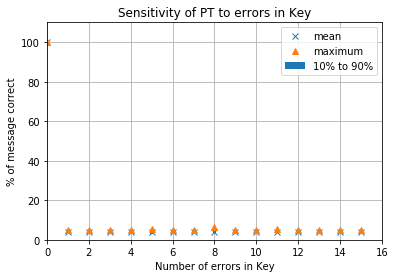

In [25]:
#plt.bar(x, y_max-y_min, width=0.2, bottom=y_min)
plt.bar(x, y_90p-y_10p, width=0.15, bottom=y_10p,label='10% to 90%')
plt.plot(x,y_mean,'x',label='mean')
plt.plot(x,y_max,'^',label='maximum')
plt.title('Sensitivity of PT to errors in Key')
plt.xlabel('Number of errors in Key')
plt.ylabel('% of message correct')
plt.xlim((0,16))
plt.ylim((0,110))
plt.legend()
plt.grid()
plt.show()

The plot above shows the results of the Monte Carlo simulation.  For each number of errors in the key, there is a range of the percentage of correct message and the maximum percent correct for each run.  Before the algorithm was modified to include the new key schedule and the increased number of rounds, this plot showed the variation in percent of message correct as a function of the number of errors in the key.  Now the plot is less interesting.  It shows that the key cannot have any errors for even partial decryption to take place.  Now the percentage of the message correct is just the random chance that a character happens to match which is about 3.8%.

In [46]:
print('random chance of a character being corret: {:.2f}'.format((1/26)*100))

random chance of a character being corret: 3.85


## 5.d) Sensitivity to changes in the message  <a id="section5d"></a>
The following cells examine the sensitivity of encryption to changing one character in the plaintext block.  Ideally, changing one character should result in all characters in the block changing.  The primary reason for including additional rounds in the Feistel network was to make this happen.

The following code compares two blocks of encrypted text with one of the blocks having the first character changed.  

In [27]:
temp_ct = encrypt(PT_int[0:block_size],key) # encrypting one block of text
pt_temp = np.copy(PT_int[0:block_size]) # change one character
pt_temp[0] = (pt_temp[0] + 1) % 26 # changing the first character in the block
temp_ct == encrypt(pt_temp,key)  # comparing the result

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

All positions in the test block have changed as a result of changing one character.

## 5.e) Repeating text in the message <a id="section5e"></a>
The following code will look at the consequences of encrypting a message with repeating text.  The encryption will use the ECB mode, followed by the CBC mode.

In [28]:
# generate new repeating text message
repeating_text = 'Mary had a little lamb '
message = repeating_text*100
print('length of repeating text: {:d}'.format(len(''.join(e for e in repeating_text if e.isalpha()).upper())))

length of repeating text: 18


In [29]:
# remove non-letter characters and convert to uppercase
PT = ''.join(e for e in message if e.isalpha()).upper()

In [30]:
# pad the message size to get to even multiple of the block size
block_size = 16  # must be an even number, since half blocks are used later
tail_size = block_size - (len(PT) % block_size)
if tail_size == block_size:
    tail_size = 0
print('number of characters to pad the message: ',tail_size)

number of characters to pad the message:  8


In [31]:
tail = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'  # this could also be from a set of random characters unique to each message
PT = PT + tail[0:tail_size]  # append necessary number of characters to end of the message
print('new message length with tail: ',len(PT))
print('number of message blocks: ',len(PT)/block_size)

new message length with tail:  1808
number of message blocks:  113.0


In [32]:
# print the converted test message
string = PT
length = 75
list_of_strings = []
for i in range(0, len(string), length):
    list_of_strings.append(string[i:length+i])

for i in list_of_strings:
    print(i)

MARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMAR
YHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHA
DALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADAL
ITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITT
LELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLEL
AMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMB
MARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMAR
YHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHA
DALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADAL
ITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITT
LELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLEL
AMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMB
MARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMARYHADALITTLELAMBMAR
YHADALITTLEL

In [33]:
# map characters to numbers, A=0, B=1, ..., Z=25
PT_int = np.asarray(list(PT),dtype='|S1').view(np.uint8) - ord('A')
PT_int

array([12,  0, 17, ...,  5,  6,  7], dtype=uint8)

In [34]:
ct_temp_int = encrypt_ECB(PT_int,key)

# convert back to ascii characters and display
ct_temp_ascii = (ct_temp_int+ord('A')).tostring().decode('ascii')

string = ct_temp_ascii
length = 75
list_of_strings = []
for i in range(0, len(string), length):
    list_of_strings.append(string[i:length+i])

for i in list_of_strings:
    print(i)

LHBEGJMDUMRKXZTOSFRLCCBVGUUYRWRSEKYFFVKWRZNOPMSFTYFEEZNKYXVBGYSWNIGHISBFWPB
SRFIIUAQSVECTVKFGSTNOIWIDCGNIQLDMUPZGOKMSNYGWKBCKPYYYPITLISSKFVKFGWVWLHBEGJ
MDUMRKXZTOSFRLCCBVGUUYRWRSEKYFFVKWRZNOPMSFTYFEEZNKYXVBGYSWNIGHISBFWPBSRFIIU
AQSVECTVKFGSTNOIWIDCGNIQLDMUPZGOKMSNYGWKBCKPYYYPITLISSKFVKFGWVWLHBEGJMDUMRK
XZTOSFRLCCBVGUUYRWRSEKYFFVKWRZNOPMSFTYFEEZNKYXVBGYSWNIGHISBFWPBSRFIIUAQSVEC
TVKFGSTNOIWIDCGNIQLDMUPZGOKMSNYGWKBCKPYYYPITLISSKFVKFGWVWLHBEGJMDUMRKXZTOSF
RLCCBVGUUYRWRSEKYFFVKWRZNOPMSFTYFEEZNKYXVBGYSWNIGHISBFWPBSRFIIUAQSVECTVKFGS
TNOIWIDCGNIQLDMUPZGOKMSNYGWKBCKPYYYPITLISSKFVKFGWVWLHBEGJMDUMRKXZTOSFRLCCBV
GUUYRWRSEKYFFVKWRZNOPMSFTYFEEZNKYXVBGYSWNIGHISBFWPBSRFIIUAQSVECTVKFGSTNOIWI
DCGNIQLDMUPZGOKMSNYGWKBCKPYYYPITLISSKFVKFGWVWLHBEGJMDUMRKXZTOSFRLCCBVGUUYRW
RSEKYFFVKWRZNOPMSFTYFEEZNKYXVBGYSWNIGHISBFWPBSRFIIUAQSVECTVKFGSTNOIWIDCGNIQ
LDMUPZGOKMSNYGWKBCKPYYYPITLISSKFVKFGWVWLHBEGJMDUMRKXZTOSFRLCCBVGUUYRWRSEKYF
FVKWRZNOPMSFTYFEEZNKYXVBGYSWNIGHISBFWPBSRFIIUAQSVECTVKFGSTNOIWIDCGNIQLDMUPZ
GOKMSNYGWKBC

Observation:  As can be seen in the ciphertext, there is a repeating pattern in the output.  This may allow an attacker to guess some of the underlying algorithm or the key. 

### Monogram frequency

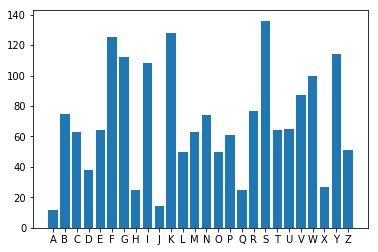

In [35]:
# using collections.Counter() to get  
# count occurance of each character in string  
mgram = Counter(ct_temp_ascii) 

sorted_dict = {key: value for key, value in sorted(mgram.items())}

plt.bar(range(len(sorted_dict)), sorted_dict.values(), align='center')
plt.xticks(range(len(sorted_dict)), list(sorted_dict.keys()))
plt.show()

In [36]:
print('the standard deviation for frequency of letters is: {:.2f}'.format(np.std(np.array(list(mgram.values())))))

the standard deviation for frequncy of letters is: 35.09


The standard deviation of the CT letter frequency is calculated above and is not much lower than 46.99 for the PT. So the ECB mode does not do a good job of flattening the letter frequency for messages with lots of repeating text.

### Chi-squared Statistic
Looking at the chi-squared value for the encrypted message to determine the level of similarity to English based in letter frequency.   

In [37]:
f_obs = np.array(list(sorted_dict.values()))  # sorted values from the mgram
f_exp = np.array(list(en_letter_freq.values())) * np.array(list(sorted_dict.values())).sum()/100
chi_value, pvalue = chisquare(f_obs, f_exp=f_exp)
print('chisquare value: {:.2f}, p valaue: {:.3e}'.format(chi_value,pvalue))

chisquare value: 4195.36, p valaue: 0.000e+00


The chi-square value is significantly higher than the chisquare value we got earlier when comparing the unencrypted message to normal english, so we can conclude that the letter frequencies in the encrypted message do not resemble English. 

### Bigram frequency

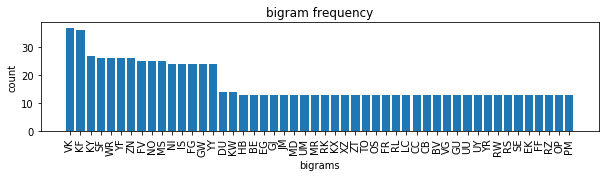

In [38]:
# count double characters, starting at beginning of text 
bigram = Counter(ct_temp_ascii[idx : idx + 2] for idx in range(len(ct_temp_ascii) - 1)) 

# count double characters, starting at 2nd letter of text 
bigram2 = Counter(ct_temp_ascii[idx : idx + 2] for idx in range(1,len(ct_temp_ascii) - 1)) 

bigram.update(bigram2) # combine groups
bigram = {k: v / 2 for k, v in bigram.items()} # divide values by 2
bigram_sorted = dict(sorted(bigram.items(), key=lambda item: item[1],reverse=True))

# slice out the first 50 for plotting
bigram_sorted_sliced = dict(itertools.islice(bigram_sorted.items(), 50))

fig = plt.figure(figsize=(10, 2))
ax = fig.add_subplot(111)

plt.bar(range(len(bigram_sorted_sliced)), bigram_sorted_sliced.values(), align='center')
plt.xticks(range(len(bigram_sorted_sliced)), list(bigram_sorted_sliced.keys()))
plt.xticks(rotation=90)
plt.autoscale(enable=True, axis='x')
plt.title('bigram frequency')
plt.ylabel('count')
plt.xlabel('bigrams')
plt.show()

The bigram frequency count for some combinations is higher for messages with repeating text.  This is yet further indication that messages with repeating text are poorly handled with the ECB mode.

The following encrypts the same message using the CBC mode.

In [39]:
ct_temp_int = encrypt_CBC(PT_int,key,IV)

# convert back to ascii characters and display
ct_temp_ascii = (ct_temp_int+ord('A')).tostring().decode('ascii')

string = ct_temp_ascii
length = 75
list_of_strings = []
for i in range(0, len(string), length):
    list_of_strings.append(string[i:length+i])

for i in list_of_strings:
    print(i)

YPSPMBMRVAGDGNIFBLKQBABFUTHPPFRTTTLONQDFREIDICBVRHQYQWIPKVAUAWMHOHSOQBFQSPV
SMCYJRJLPGCCSWSFUCHBWJPTJBNUWAHMDTMHHEHKBNMXVHKYBEANJPHZUTHOJKPFKKWQEVUNSDC
XSBDRMDOFRQQRKBWUKQPVLHEWGSLUCZSWMCDCNJZRYAZMTIUIQIZKSDYOUPLMVPWFBMAQGCBOML
VNCWOMFTQNBXDIZCGXJNFKLRTHNMWEILLFGNKNTAPAXFEUAFEDMUDNIMDJLKFKXGIWLLRIREVDD
UVONHOBGREKNAJIAXIVSQWXUUZAXFOKAQKWTCZLWFEAOCRNZPNFJIZTZUPEMBZIGICEFOGAMENN
ZJDUZKKRRGERQBVLWEVHQITMTTLNMYCSXQLZSPGTKIFVFLATCBPYARNVOQHVBWEYGIGHPGPBFKB
EIYHTZAQHSRVFKREPLXSVXAYHZMYUQJDMPEBNXFVVSQWXVPERMDXLOTSMKGAYDIHDHPTYUTVFTF
FZULUWGGEITENRFPTEPYJFYIMHJSWPUEPWFCSMNDZULIWDQOABSYGOISFKKRKNCECMPXUNICJCI
REOZHQIYXXRGQKGLVJNRFJXUIEAZKNOJWWMTVZRJFPLXFXRXWNIIHTOKLZKHAPVVYRZRFAXBNCU
UOUDWJBTLBJFPQGHKEIRZAZAGUASXYLALKBMNPEYMDOEPTVGANHASTPXZDACPXMRZSMQRDHLATO
KQAYFCMNKUABKYJFXIHQNXQWGRIBIDUFHBMMVMGYLKRAHEKVIYQLFMVDJLTKQJOTOOLWXNRPWTZ
LMTJBIKPTSWREOLVHRRHNOGAMTUOJCNBDBSDVHVNWFVOXOOQBJVHVSTONRTIUQUNGJASLMJZVXV
XRDCONXZPQVVAUYWJDSDRQDGQCTDSYINFOXXYSQAJCZHTPEHRCGVYFHBBAPCOYTKJKZKOBERAVH
YXXDECGFYZGI

Observation:  The CBC mode seems to do a good job of hiding the repetition in the message. 

### Monogram frequency

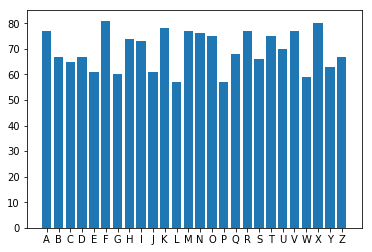

In [40]:
# using collections.Counter() to get  
# count occurance of each character in string  
mgram = Counter(ct_temp_ascii) 

sorted_dict = {key: value for key, value in sorted(mgram.items())}

plt.bar(range(len(sorted_dict)), sorted_dict.values(), align='center')
plt.xticks(range(len(sorted_dict)), list(sorted_dict.keys()))
plt.show()

In [41]:
print('the standard deviation for frequency of letters is: {:.2f}'.format(np.std(np.array(list(mgram.values())))))

the standard deviation for frequncy of letters is: 7.41


The standard deviation of the CT letter frequency calculated above is much lower than 46.99 for the PT. 

### Bigram frequency

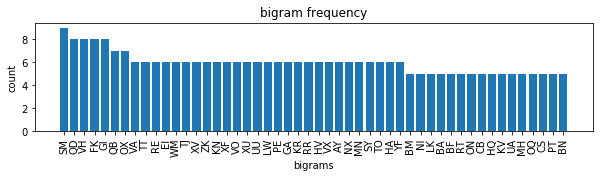

In [42]:
# count double characters, starting at beginning of text 
bigram = Counter(ct_temp_ascii[idx : idx + 2] for idx in range(len(ct_temp_ascii) - 1)) 

# count double characters, starting at 2nd letter of text 
bigram2 = Counter(ct_temp_ascii[idx : idx + 2] for idx in range(1,len(ct_temp_ascii) - 1)) 

bigram.update(bigram2) # combine groups
bigram = {k: v / 2 for k, v in bigram.items()} # divide values by 2
bigram_sorted = dict(sorted(bigram.items(), key=lambda item: item[1],reverse=True))

# slice out the first 50 fro plotting
bigram_sorted_sliced = dict(itertools.islice(bigram_sorted.items(), 50))

fig = plt.figure(figsize=(10, 2))
ax = fig.add_subplot(111)

plt.bar(range(len(bigram_sorted_sliced)), bigram_sorted_sliced.values(), align='center')
plt.xticks(range(len(bigram_sorted_sliced)), list(bigram_sorted_sliced.keys()))
plt.xticks(rotation=90)
plt.autoscale(enable=True, axis='x')
plt.title('bigram frequency')
plt.ylabel('count')
plt.xlabel('bigrams')
plt.show()

Observation: By using the CBC mode, the repeating text in the message is hidden, which is one of the reasons that the CBC mode is preferred over the ECB mode.  Other reasons are described in [18].  

## 5.f) Round function properties <a id="section5f"></a>
Moved to a new notebook.  

## 5.g) Section summary <a id="section5g"></a>
In this section the ability of the cipher algorithm to flattened the ciphertext letter frequency was examined.  Some calculations were made concerning the key space.  The keyspace is sufficiently large to discourage an exhaustive search of the key space.  Repeating text in the message was analysed with ECB and CBC modes of encryption. CBC is the preferred mode.  Errors in the key and one character changes to the plaintext were also examined.  The cipher algorithm was strengthened with a new key schedule and to include additional rounds as a result of working through this notebook.

## 5.h) References <a id="section5h"></a>
1. Wikipedia contributors. (2021, January 22). Enigma machine. In Wikipedia, The Free Encyclopedia. Retrieved 11:39, January 22, 2021, from https://en.wikipedia.org/w/index.php?title=Enigma_machine
2. Wikipedia contributors. (2021, January 13). List of dictionaries by number of words. In Wikipedia, The Free Encyclopedia. Retrieved 12:15, January 15, 2021, from https://en.wikipedia.org/w/index.php?title=List_of_dictionaries_by_number_of_words